In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import seaborn as sns

In [ ]:
def preprocessing():
    #reading the csv file
    df = pd.read_csv('CUACA MALANG 2000-2021.csv')
    #dropping unnecessary columns
    df = df.drop(['Tn','Tx','ff_x','ddd_x','ff_avg','ddd_car'], axis =1)
    #adjusting the date columns
    from datetime import date,timedelta
    datedata = []
    start_yr, start_mo, start_dd = 2000, 1, 1
    end_yr, end_mo, end_dd = 2022,3,31
    start_date = date(start_yr, start_mo, start_dd) 
    end_date = date(end_yr, end_mo, end_dd) 
    delta = end_date - start_date 
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        datedata.append(day)
    df['Date'] = datedata
    df['YR'] = [d.year for d in df['Date']]
    df['MO'] = [d.month for d in df['Date']]
    df['DD'] = [d.day for d in df['Date']]
    #filling null values in each column with interpolation values
    df['Tavg'] = df['Tavg'].interpolate()
    df['RH_avg'] = df['RH_avg'].interpolate()
    df['ss'] = df['ss'].interpolate()
    df['RR'] = df['RR'].fillna(0)
    import warnings
    warnings.filterwarnings('ignore')
    for index, value in enumerate(df['RR']):
        if value == 8888:
            df['RR'][index] = np.nan
        elif value == 9999:
            df['RR'][index] = np.nan
    df['RR'] = df['RR'].interpolate()
    df = df[['Date', 'YR','MO','DD','Tavg','RH_avg','RR','ss']]
    return df

In [ ]:
df = preprocessing()
df

,Date,YR,MO,DD,Tavg,RH_avg,RR,ss
0,2000-01-01,2000,1,1,24.1,69.0,82.0,5.4
1,2000-01-02,2000,1,2,22.9,77.0,0.0,1.2
2,2000-01-03,2000,1,3,23.8,78.0,14.0,4.1
3,2000-01-04,2000,1,4,24.2,77.0,10.0,1.3
4,2000-01-05,2000,1,5,23.4,78.0,6.0,3.6
...,...,...,...,...,...,...,...,...
8121,2022-03-27,2022,3,27,23.2,88.0,3.0,1.6
8122,2022-03-28,2022,3,28,23.8,82.0,4.7,0.7
8123,2022-03-29,2022,3,29,23.8,84.0,5.0,7.5
8124,2022-03-30,2022,3,30,24.8,79.0,3.4,4.7


In [ ]:
df['Tavg_n-1'] = df.Tavg.shift(1)
df['RH_avg_n-1'] = df.RH_avg.shift(1)
df['ss_n-1'] = df.ss.shift(1)
df

,Date,YR,MO,DD,Tavg,RH_avg,RR,ss,Tavg_n-1,RH_avg_n-1,ss_n-1
0,2000-01-01,2000,1,1,24.1,69.0,82.0,5.4,NaN,NaN,NaN
1,2000-01-02,2000,1,2,22.9,77.0,0.0,1.2,24.1,69.0,5.4
2,2000-01-03,2000,1,3,23.8,78.0,14.0,4.1,22.9,77.0,1.2
3,2000-01-04,2000,1,4,24.2,77.0,10.0,1.3,23.8,78.0,4.1
4,2000-01-05,2000,1,5,23.4,78.0,6.0,3.6,24.2,77.0,1.3
...,...,...,...,...,...,...,...,...,...,...,...
8121,2022-03-27,2022,3,27,23.2,88.0,3.0,1.6,24.3,82.0,1.5
8122,2022-03-28,2022,3,28,23.8,82.0,4.7,0.7,23.2,88.0,1.6
8123,2022-03-29,2022,3,29,23.8,84.0,5.0,7.5,23.8,82.0,0.7
8124,2022-03-30,2022,3,30,24.8,79.0,3.4,4.7,23.8,84.0,7.5


In [ ]:
df_2016 = df[df['YR'] >= 2016]

In [ ]:
df_train = df_2016[df_2016['YR'] < 2022]
df_test = df_2016[df_2016['YR'] == 2022]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def regression_test(ypred,ytest):
    MSE = mean_squared_error(ypred,ytest, squared = True)
    MAE = mean_absolute_error(ypred,ytest)
    return MSE,MAE

In [ ]:
def rf_eval(y_test,y_pred):
    collist = ['Tavg','RH_avg','ss']
    evaluation = pd.DataFrame(columns = ['Feature','MAE','MSE'])
    MSE = []
    MAE = []
    for i in range(0,len(collist)):
        MSE.append((regression_test(y_pred[:,i],y_test[collist[i]]))[0])
        MAE.append((regression_test(y_pred[:,i],y_test[collist[i]]))[1])
    evaluation['Feature'] = collist
    evaluation['MAE'] = MAE
    evaluation['MSE'] = MSE
    evaluation = evaluation.set_index(['Feature'])
    return evaluation

In [ ]:
def evaluation_plot(y_test,y_pred,title):
    df = rf_eval(y_test,y_pred)
    y_test = np.array(y_test)
    fig , [[ax1,ax2],[ax3,ax4]]=plt.subplots(nrows = 2, ncols = 2,figsize = (16,7))
    ax1.plot(y_test[:,0],label = 'Actual')
    ax1.plot(y_pred[:,0],label = 'Predicted')
    ax1.set_title('Tavg Prediction vs Actual')
    ax1.legend()
    ax2.plot(y_test[:,1],label = 'Actual')
    ax2.plot(y_pred[:,1],label = 'Predicted')
    ax2.set_title('RH_avg Prediction vs Actual')
    ax2.legend()
    ax3.plot(y_test[:,2],label = 'Actual')
    ax3.plot(y_pred[:,2],label = 'Predicted')
    ax3.set_title('ss Prediction vs Actual')
    ax3.legend()
    ax4.axis('off')
    ax4.set_title(title)
    ax4.table(cellText = df.values,rowLabels = df.index, bbox= [0,0,1,1],colLabels = df.columns)

In [ ]:
from datetime import date,timedelta
def date_sequence(start_yr,start_mo,start_dd,end_yr,end_mo,end_dd):
    datedata = []
    start_date = date(start_yr, start_mo, start_dd) 
    end_date = date(end_yr, end_mo, end_dd) 
    delta = end_date - start_date 
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        datedata.append(day)
    datedata = pd.to_datetime(datedata)
    dataframe = pd.DataFrame()
    dataframe['Date'] = datedata
    dataframe['YR'] = [d.year for d in dataframe['Date']]
    dataframe['MO'] = [d.month for d in dataframe['Date']]
    dataframe['DD'] = [d.day for d in dataframe['Date']]
    return dataframe

In [ ]:
x_train = df_train[['MO','DD','Tavg_n-1','RH_avg_n-1','ss_n-1']]
y_train = df_train[['Tavg','RH_avg','ss']]
x_test = df_test[['MO','DD','Tavg_n-1','RH_avg_n-1','ss_n-1']]
y_test = df_test[['Tavg','RH_avg','ss']]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
x_train = df_train[['MO','DD','Tavg_n-1','RH_avg_n-1','ss_n-1']]
y_train = df_train[['Tavg','RH_avg','ss']]
x_test = df_test[['MO','DD','Tavg_n-1','RH_avg_n-1','ss_n-1']]
y_test = df_test[['Tavg','RH_avg','ss']]
clf_1 = RandomForestRegressor(n_estimators = 100)
clf_1.fit(x_train,y_train)
clf_pred = clf_1.predict(x_test)

In [ ]:
pred_df = date_sequence(2022,1,1,2022,3,31)
pred_df = pred_df.drop(['Date','YR'],axis =1)
pred_array = np.array(pred_df)
last_x = np.array(x_test[:1])
last_x = last_x[:,2:]
results = []

for i in range(0,len(pred_array)):
    to_predict = np.append(pred_array[i],last_x).reshape(1,len(x_train.columns.tolist()))
    predicted = clf_1.predict(to_predict)
    results = np.append(results,predicted)
    last_x = predicted    

In [ ]:
def divide_chunks(l,n):
    for i in range(0,len(l),n):
        yield l[i:i+n]

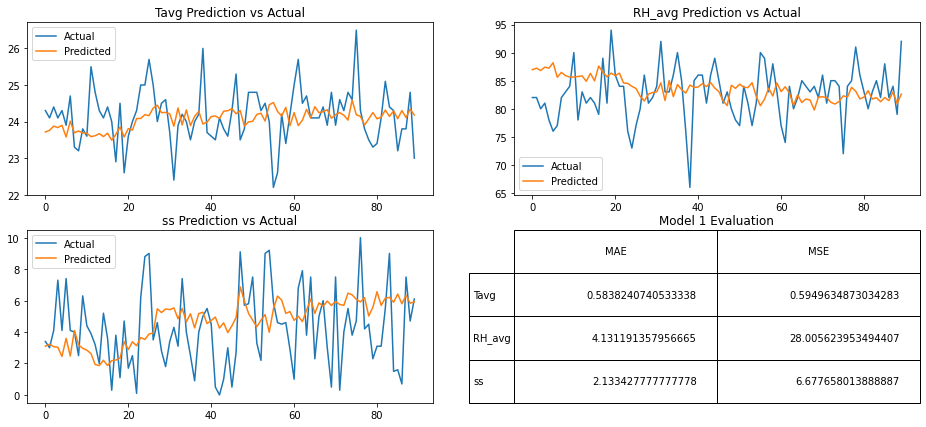

In [ ]:
new_results = np.array(list(((divide_chunks(results,3)))))
evaluation_plot(y_test,new_results,'Model 1 Evaluation')

In [ ]:
x_train_2 = df_train[['YR','MO','DD']]
y_train_2 = df_train[['Tavg','RH_avg','ss']]
x_test_2 = df_test[['YR','MO','DD']]
y_test_2 =df_test[['Tavg','RH_avg','ss']]
clf_2 = RandomForestRegressor(n_estimators = 100)
clf_2.fit(x_train_2,y_train_2)
y_pred_2 = clf_2.predict(x_test_2)

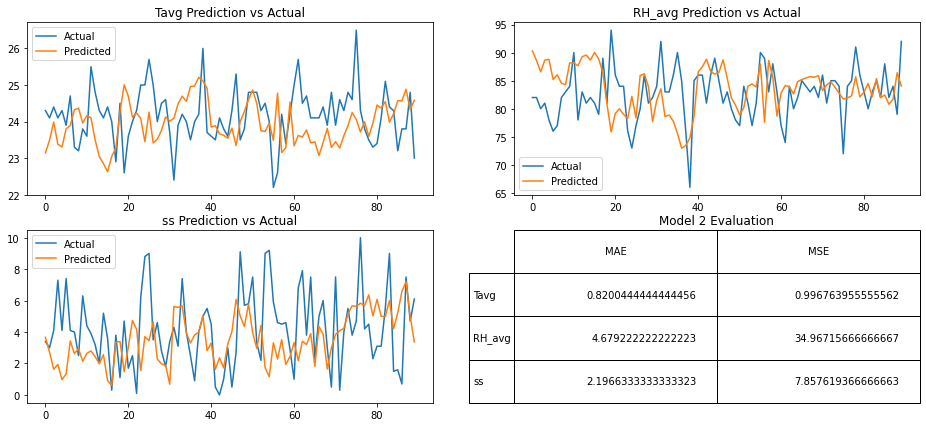

In [ ]:
evaluation_plot(y_test,y_pred_2,title = 'Model 2 Evaluation')

In [ ]:
x_train_3 = df_train[['MO','DD']]
y_train_3 = df_train[['Tavg','RH_avg','ss']]
x_test_3 = df_test[['MO','DD']]
y_test_3 =df_test[['Tavg','RH_avg','ss']]
clf_3 = RandomForestRegressor(n_estimators = 100)
clf_3.fit(x_train_3,y_train_3)
y_pred_3 = clf_3.predict(x_test_3)

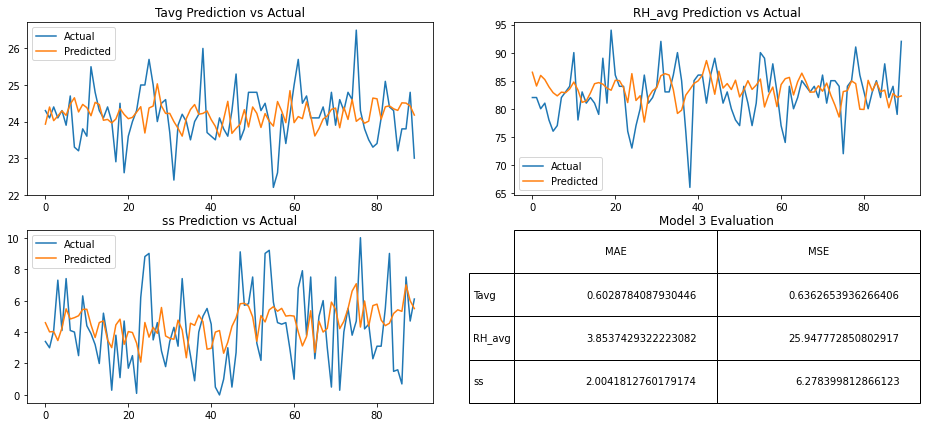

In [ ]:
evaluation_plot(y_test,y_pred_3,title = 'Model 3 Evaluation')

In [ ]:
import pickle
#pickle.dump(clf_3,open('Weather Prediction','wb'))